# Projet de Visualisation de données médicales

In [155]:
# Installation des dépendances
#!pip install -q SimpleITK nibabel pydicom scikit-image matplotlib seaborn 
#!pip install opencv-python plotly scipy numpy vtk open3d torch torchvision 
#!pip install kaggle scikit-learn keras tensorflow
#!pip install fuzzy-c-means


# importation des bibliothèques

In [23]:
import seaborn as sns
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
from fcmeans import FCM
from skimage import color
from skimage.filters import threshold_local
from sklearn.cluster import KMeans
import torch
import torchvision.transforms as transforms
from torchvision import models
from skimage.measure import label, regionprops


## Analyse exploratoire
Dans cette analys nous allons voir les differente technique analyse visuel d'image médicale qu'un data scientist peut applique dans le domaine medicale


###  Tout d'abord nous proccédons au Chargement des images d'entraînement et de test :
* Charger les images à partir des dossiers Training/ et Testing/.
* Redimensionner les images à une taille uniforme (par exemple, 300x300).

In [31]:
# Configuration des chemins et paramètres
path_train = 'Training/'   # Dossier d'images d'entraînement
path_test = 'Testing/'     # Dossier d'images de test
img_size = 300             # Taille de l'image après redimensionnement

# Initialisation des listes pour stocker les images et labels
train_img = []
train_labels = []
test_img = []
test_labels = []

In [32]:
# Étape de chargement des images d'entraînement
for i in os.listdir(path_train):
    for j in os.listdir(path_train + i):
        img = cv2.resize(cv2.imread(path_train + i + '/' + j), (img_size, img_size))
        train_img.append(img)
        train_labels.append(i)

# Étape de chargement des images de test
for i in os.listdir(path_test):
    for j in os.listdir(path_test + i):
        img = cv2.resize(cv2.imread(path_test + i + '/' + j), (img_size, img_size))
        test_img.append(img)
        test_labels.append(i)

#  etape de Conversion des listes en arrays NumPy
train_img = np.array(train_img)
test_img = np.array(test_img)

### * Visualisation des image disponible dans le dataset

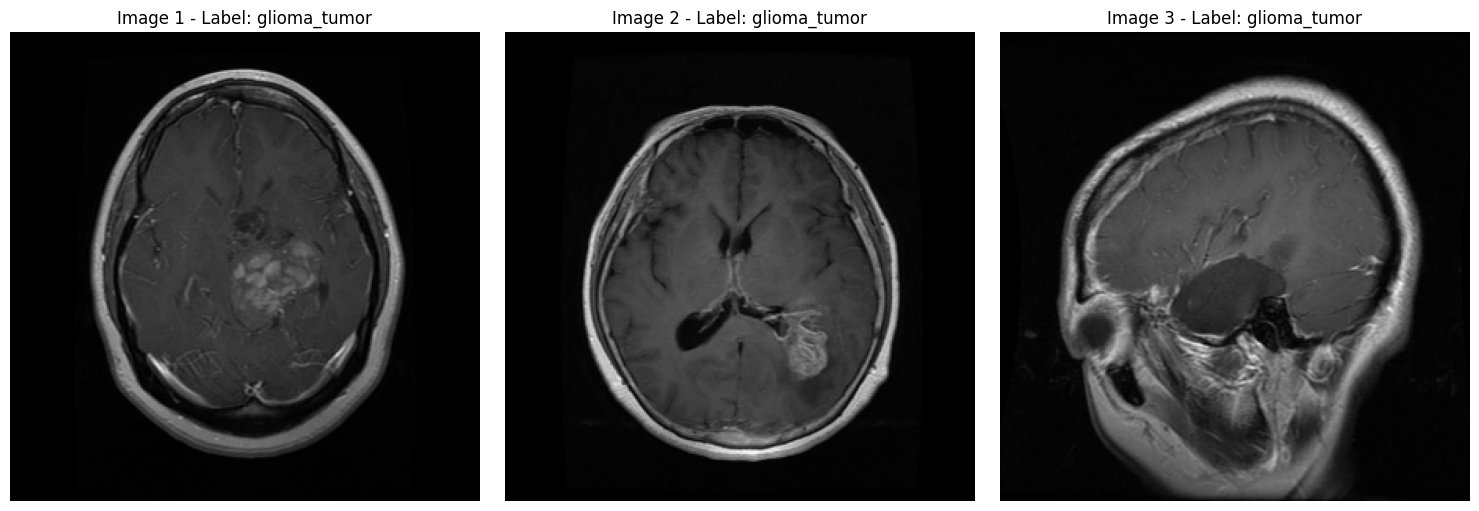

In [ ]:
# Fonction pour échantillonner les pixels
def sample_pixels(image, num_samples=1000):
    flat_image = image.reshape(-1, 3)
    indices = np.random.choice(flat_image.shape[0], num_samples, replace=False)
    return flat_image[indices]

# Fonction pour préparer les données de visualisation 3D
def prepare_3d_data(images, labels):
    x_coords, y_coords, z_coords, color_labels = [], [], [], []

    for img, label in zip(images[:3], labels[:3]):
        sampled_pixels = sample_pixels(img)
        
        x_coords.extend(sampled_pixels[:, 0])
        y_coords.extend(sampled_pixels[:, 1])
        z_coords.extend(sampled_pixels[:, 2])
        color_labels.extend([label] * sampled_pixels.shape[0])
    return pd.DataFrame({
        'x': x_coords,
        'y': y_coords,
        'z': z_coords,
        'color': color_labels
    })

# Visualisation des images originales contenue dans le dataset
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(cv2.cvtColor(train_img[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i+1} - Label: {train_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [48]:
#!pip install pyswarm

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4484 sha256=817a31021e32658dfd3d39567230bf6f1e61c8ffc8c5c8709fd3713f4075daba
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\93\15\89\3970ef96abd6123028010a90f007c4e6a2bed700db0aa2d36a
Successfully built pyswarm


In [97]:
# Convertir en tableau NumPy
images = np.array(images)


### 1. Recalage d'Images


Dans cette partie nous avons decidée d'illustrer comment utiliser OpenCV pour effectuer un recalage d'images en utilisant une méthode rigide. Les étapes incluent la détection de points clés avec ORB, l'appariement des descripteurs entre les images, le calcul d'une matrice de transformation homographique et l'application de cette transformation pour obtenir une image alignée. Ce processus est essentiel dans divers domaines tels que la vision par ordinateur et l'imagerie médicale pour fusionner ou comparer plusieurs images.

In [ ]:
![recallage]("C:\Users\user\Documents\Dossier Academique 2024\VISUALISATION\Presentation_Brenda_marie_Ilham_moi\recallage.png")


Convepte clé a retenir ici sont : 
* Point descripteur ORB : Un point d'intérêt détecté dans une image (par FAST), décrit par un descripteur binaire robuste à la rotation (par BRIEF).

* Point BFMatcher : Le résultat de la correspondance entre des descripteurs de points extraits de différentes images, réalisée par l'algorithme de correspondance brute-force (BFMatcher)

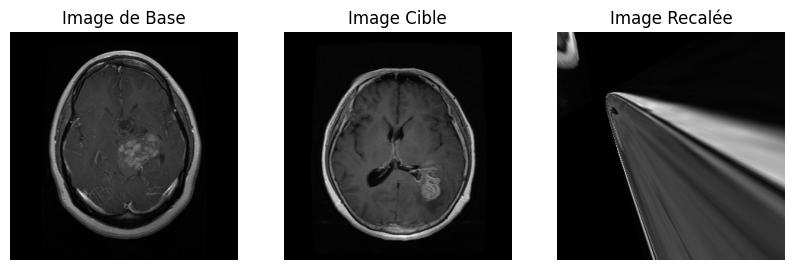

In [101]:
# Recalage d'Images pa une simple utilisation de OpenCV (méthode rigide)
base_image = img_original  # Utiliser l'image originale comme base (vous pouvez charger une autre image pour le recalage)
target_image = images[1]   # Utiliser la deuxième image du dataset comme cible

# Convertir les images en niveaux de gris
base_gray = cv2.cvtColor(base_image, cv2.COLOR_BGR2GRAY)
target_gray = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)

# Trouver les points clés et descripteurs avec ORB(c'est un algorihtme qui fixe les points pouqu'il reste invariant sur une image)
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(base_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(target_gray, None)

# Appariement des descripteurs avec BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Tri des matches par distance et extraction des points correspondants
matches = sorted(matches, key=lambda x: x.distance)
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Calculer la matrice de transformation affine
matrix, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)

# Appliquer le recalage à l'image cible
registered_image = cv2.warpPerspective(target_image, matrix, (base_image.shape[1], base_image.shape[0]))

# Affichage des résultats de recalage
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(base_image)
plt.title('Image de Base')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(target_image)
plt.title('Image Cible')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(registered_image)
plt.title('Image Recalée')
plt.axis('off')

plt.show()


### 2. Visualisation Multi-Planar (MPR)


* Coupe axiale : On peut observer les différentes sections du cerveau, y compris des régions spécifiques comme la matière blanche, la matière grise, et d'autres structures internes.
* Coupe sagittale : On peut examiner le profil du cerveau, en observant des anomalies comme les tumeurs ou des lésions dans les régions spécifiques.
* Coupe coronale : Elle offre une vue de l’avant du cerveau et peut montrer des détails utiles concernant les différentes régions du cerveau dans leur orientation relative.



NB. ICI C'EST JUSTE UNE DIFFERENCE QUI S'OBSERVE AU MICROSCOP CAR LES PARTICULE DU CERVEAUX SON INIMENT PETIT

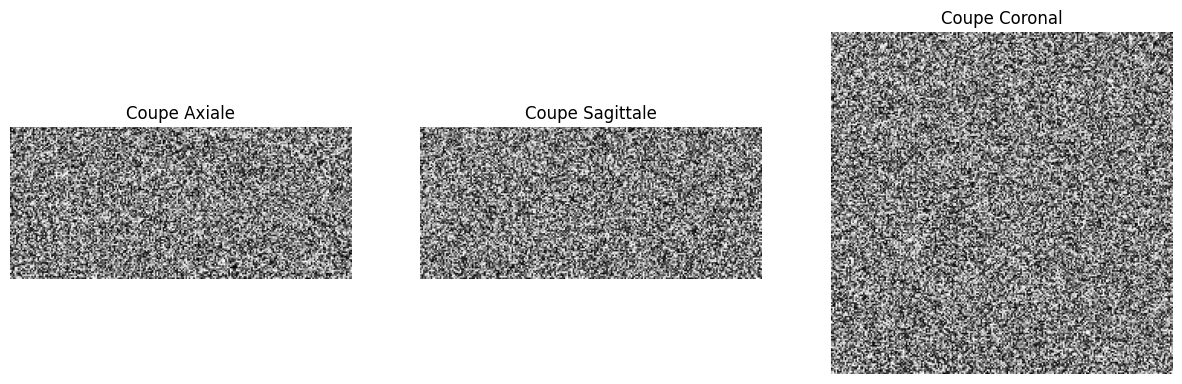

In [25]:
import numpy as np


# Visualisation Multi-Planar (MPR) : Reconstruction simple en utilisant NumPy 
# Supposons que nous avons un volume_3d simulé pour cet exemple.
volume_3d = np.random.rand(100, img_size, img_size) * 255  # Simuler un volume IRM aléatoire

axial_slice = volume_3d[:, :, volume_3d.shape[0] // 2]   # Couper une coupe axiale au milieu du volume
sagittal_slice = volume_3d[:, volume_3d.shape[1] // 2, :]   # Couper une coupe sagittale au milieu du volume
coronal_slice = volume_3d[volume_3d.shape[0] // 2,:,:]     # Couper une coupe coronale au milieu du volume

# Affichage des coupes MPR
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(axial_slice.astype(np.uint8), cmap='gray')
plt.title('Coupe Axiale')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sagittal_slice.astype(np.uint8), cmap='gray')
plt.title('Coupe Sagittale')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(coronal_slice.astype(np.uint8), cmap='gray')
plt.title('Coupe Coronal')
plt.axis('off')

plt.show()


## 3. Projection d'Intensité Maximale (MIP)
La projection MIP est couramment utilisée pour des techniques d'imagerie comme les angiographies (imagerie des vaisseaux sanguins), où l'on cherche à mettre en évidence les vaisseaux sanguins qui ont une intensité plus élevée par rapport aux tissus environnants. Dans un scanner 3D, la projection MIP peut être utilisée pour afficher les artères ou les veines en projetant uniquement les pixels les plus lumineux (intenses) sur chaque plan de coupe.


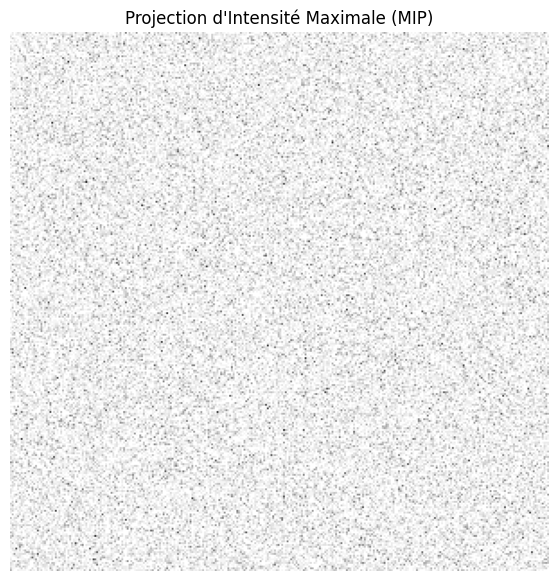

In [103]:
# Projection d'Intensité Maximale (MIP)
mip_image = np.max(volume_3d[:, :, :], axis=0)   # Projection maximale à travers l'axe z pour créer une image MIP

# Affichage du MIP
plt.figure(figsize=(7, 7))
plt.imshow(mip_image.astype(np.uint8), cmap='gray')
plt.title('Projection d\'Intensité Maximale (MIP)')
plt.axis('off')
plt.show()


### 4. Filtrage Gaussien & Median

Le filtrage gaussien est utile pour la réduction du bruit global dans une image et pour l'amélioration des structures avec des transitions lentes, mais il peut estomper des détails fins et des bords importants.
Le filtrage médian est plus adapté pour réduire les bruits impulsifs tout en préservant les contours nets, ce qui est particulièrement utile pour des images comme les radiographies et les images de scanner où les bords des structures sont critiques.



Les médecins doivent être conscients des limites de ces filtres et choisir la méthode de filtrage en fonction de l'anomalie qu'ils cherchent à détecter et du type d'image qu'ils examinent.


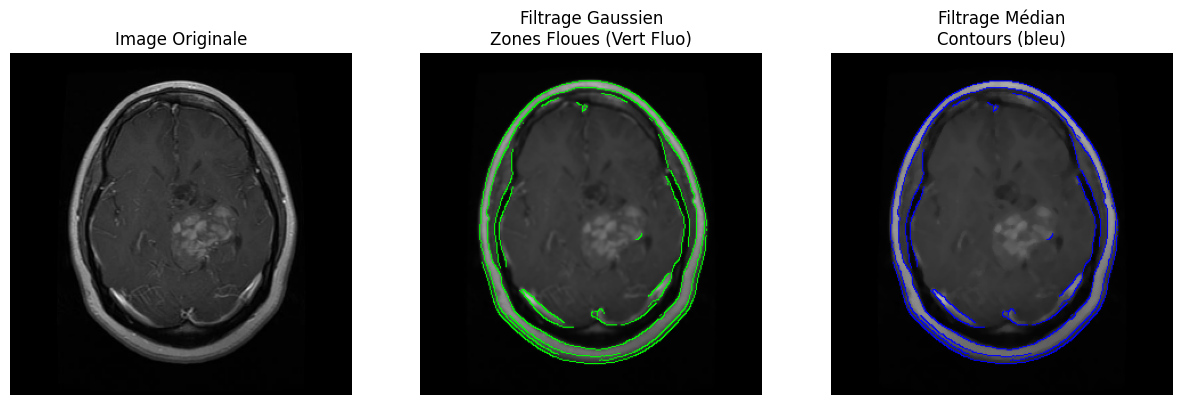

In [127]:
# Convertir en tableau NumPy
images = np.array(images)

# Sélectionner une image pour démonstration
img_original = images[0]  # Prendre la première image pour le traitement

# Filtrage Gaussien
filtered_gaussian_img = cv2.GaussianBlur(img_original, (5, 5), 0)

# Filtrage Médian
filtered_median_img = cv2.medianBlur(img_original, 5)

# Détection des contours dans l'image filtrée par médiane
edges_median = cv2.Canny(filtered_median_img, 100, 200)

# Créer une image vide pour mettre en évidence les différences
highlighted_gaussian = filtered_gaussian_img.copy()
highlighted_median = filtered_median_img.copy()

# Mettre en évidence les zones floues du filtrage gaussien (vert fluo)
highlighted_gaussian[edges_median > 0] = [0, 255, 0]  # Vert fluo

# Mettre en évidence les contours du filtrage médian (rouge)
highlighted_median[edges_median > 0] = [255, 0, 0]    # Rouge

# Affichage des résultats
plt.figure(figsize=(15, 10))

# Affichage de l'image originale
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))  # Conversion BGR à RGB pour affichage correct
plt.title('Image Originale')
plt.axis('off')

# Affichage du filtrage gaussien avec zones floues mises en évidence
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(highlighted_gaussian, cv2.COLOR_BGR2RGB))  # Affichage de l'image filtrée par Gaussien avec mise en évidence
plt.title('Filtrage Gaussien\nZones Floues (Vert Fluo)')
plt.axis('off')

# Affichage du filtrage médian avec contours mis en évidence
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(highlighted_median, cv2.COLOR_BGR2RGB))  # Affichage de l'image filtrée par Médiane avec mise en évidence
plt.title('Filtrage Médian\nContours (bleu)')
plt.axis('off')

plt.show()

### NB: Effet sur l'Image :
* Filtrage Gaussien : Peut entraîner un flou général de l'image.
* Filtrage Médian : Préserve mieux les détails et les contours des objets dans l'image.

## 5. Analyse de Texture


pip install --upgrade scikit-image


In [151]:
#!pip install --upgrade scikit-image


l'analyse de texture permet de fournir des informations quantifiables et précises sur les caractéristiques de la tumeur, telles que son type, son agressivité, sa réponse au traitement, ainsi que sur l'évolution de la maladie. 

En superposant des cartes de chaleur basées sur des mesures de texture, les médecins peuvent visualiser plus facilement les zones critiques de la tumeur,

 ce qui les aide à prendre des décisions cliniques éclairées pour améliorer le diagnostic, la planification du traitement et le suivi du patient.

Valeur de contraste extraite : 77.76931995540691


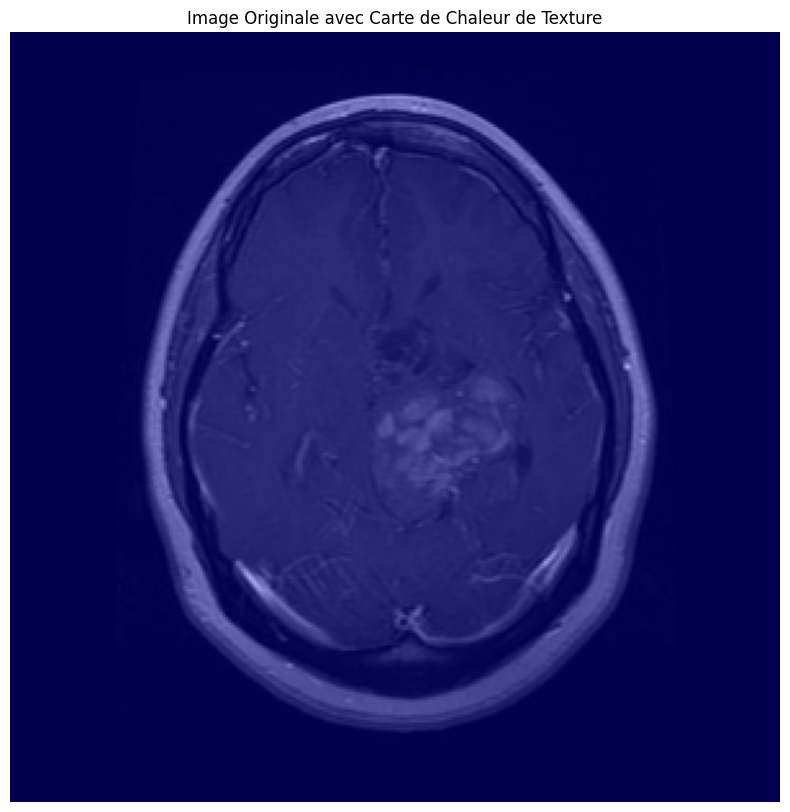

In [126]:
from skimage.feature import graycomatrix, graycoprops  

# Sélectionner une image pour démonstration
img_original = images[0]  # Prendre la première image pour le traitement

# Analyse de Texture : Fonction utilisant la matrice de co-occurrence pour extraire des caractéristiques de texture.
def texture_analysis(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convertir en niveaux de gris
    
    # Calculer la matrice de co-occurrence
    glcm = graycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    
    # Extraire des caractéristiques comme le contraste
    contrast_value = graycoprops(glcm, 'contrast')[0][0]
    
    return contrast_value

# Calculer la valeur de contraste
contrast_value = texture_analysis(img_original)

print(f'Valeur de contraste extraite : {contrast_value}')

# Création d'une carte de chaleur basée sur le contraste
def create_heatmap(image, contrast_value):
    # Créer une image vide pour l'overlay
    heatmap = np.zeros_like(image, dtype=np.float32)
    
    # Remplir la carte de chaleur avec des valeurs basées sur le contraste (normalisées)
    heatmap[..., 0] = contrast_value * 255  # Rouge
    heatmap[..., 1] = (1 - contrast_value) * 255  # Vert (inverse)
    
    # Normaliser pour obtenir des valeurs entre 0 et 1
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    
    return heatmap

# Créer une carte de chaleur
heatmap = create_heatmap(img_original, contrast_value)

# Superposer la carte de chaleur sur l'image originale
overlay_img = cv2.addWeighted(img_original, 0.7, heatmap, 0.3, 0)

# Affichage des résultats
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))  # Afficher l'image originale avec overlay
plt.title('Image Originale avec Carte de Chaleur de Texture')
plt.axis('off')
plt.show()

NB: On n'applique pas n'importe quel filtre on fait tout selon le contraste déteminé

## 6. Suivi Longitudinal : Comparaison simple entre deux images pour observer les changements.

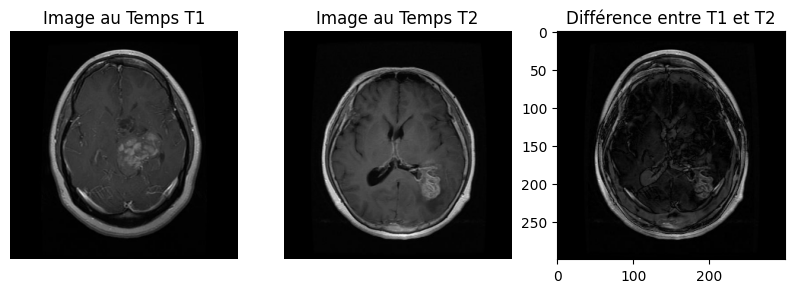

In [132]:
image_t1 = images[0]    # Image à T1 (première image du dataset)
image_t2 = images[1]    # Image à T2 (deuxième image du dataset)

difference_image = cv2.absdiff(image_t1.astype(np.uint8), image_t2.astype(np.uint8)) 

# Affichage des résultats de suivi longitudinal 
plt.figure(figsize=(10,5))
    
plt.subplot(1, 3, 1)
plt.imshow(image_t1)
plt.title('Image au Temps T1')
plt.axis('off')

    
plt.subplot(1, 3, 2)
plt.imshow(image_t2)
plt.title('Image au Temps T2')
plt.axis('off')

    
plt.subplot(1, 3, 3)
plt.imshow(difference_image,cmap='gray')
plt.title('Différence entre T1 et T2')
    
for ax in plt.gcf().axes:
    ax.label_outer()  
        
    
    plt.show()


La comparaison entre les images à T1 et T2 fournit des informations essentielles sur l'évolution de la tumeur cérébrale. En analysant les différences d'intensité et de contraste, le médecin peut :

* Suivre l'évolution de la tumeur (croissance, régression, etc.)

* Évaluer la réponse au traitement

* Détecter des complications ou des métastases

* Planifier les soins de suivi et ajuster les traitements si nécessaire.

## * Fuzzy C-Means (FCM)
l'utilisation de Fuzzy C-Means dans l'analyse des images cérébrales pour la détection du cancer présente des avantages significatifs, notamment une meilleure gestion des incertitudes, une segmentation plus robuste et une détection plus précise des anomalies tumorales. Grâce à sa capacité à attribuer des degrés d'appartenance à plusieurs classes, FCM permet une segmentation plus fine et plus fiable des tumeurs cérébrales, ce qui aide les médecins à mieux comprendre l'étendue de la maladie, à suivre l'évolution des tumeurs et à ajuster les traitements de manière plus ciblée et efficace.

In [134]:
import os
import cv2
import numpy as np
from fcmeans import FCM
import matplotlib.pyplot as plt

# Configuration des paramètres
path_train = 'Training/'
img_size = 300

# Chargement des images
def load_images(path):
    images = []
    for i in os.listdir(path):
        for j in os.listdir(os.path.join(path, i)):
            img = cv2.resize(cv2.imread(os.path.join(path, i, j)), (img_size, img_size))
            images.append(img)
    return np.array(images)

# Prétraitement des images
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    return equalized

# Méthode FCM
def fcm_segmentation(img, n_clusters=3):
    img_flat = img.flatten().reshape(-1, 1)
    fcm = FCM(n_clusters=n_clusters)
    fcm.fit(img_flat)
    labels = fcm.predict(img_flat)
    return labels.reshape(img.shape)

# Charger et prétraiter les images
train_img = load_images(path_train)
img_original = train_img[0]
img_preprocessed = preprocess_image(img_original)


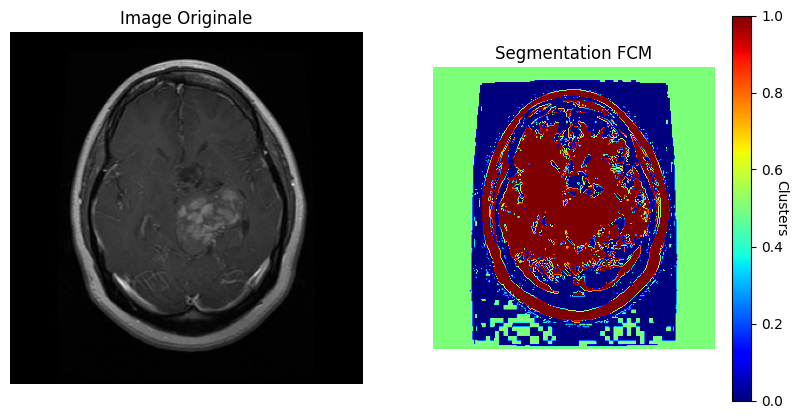

In [139]:
# Segmentation avec FCM
fcm_segmented = fcm_segmentation(img_preprocessed)

# Visualisation des résultats avec légendes de couleur
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.title('Image Originale')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(fcm_segmented, cmap='jet')
plt.title('Segmentation FCM')
plt.axis('off')

# Ajouter une légende pour les couleurs
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=plt.gca(), orientation='vertical')
cbar.set_label('Clusters', rotation=270)

plt.show()

## Optimisation de FCM


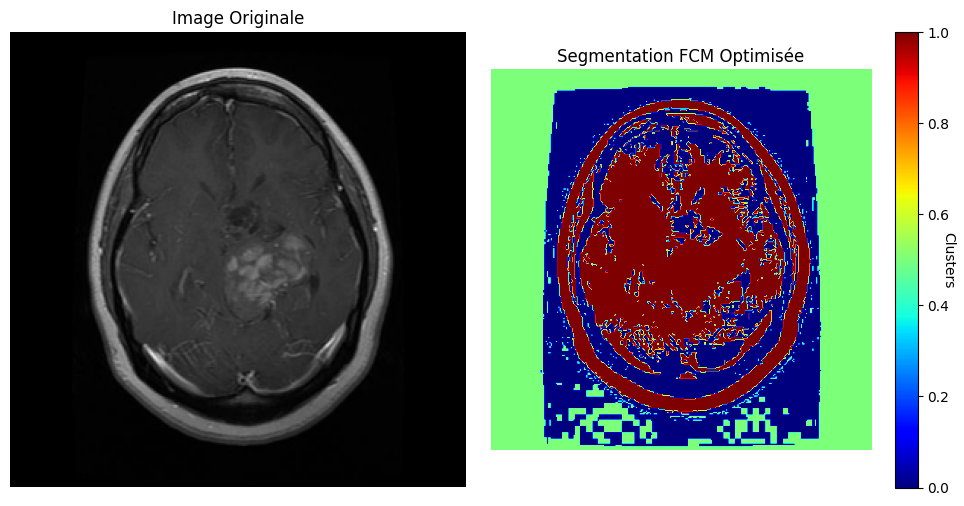

In [143]:
# Optimisation de la méthode FCM
def optimized_fcm_segmentation(img, n_clusters=3):
    img_flat = img.flatten().reshape(-1, 1)
    fcm = FCM(n_clusters=n_clusters)
    
    # Ajustement du modèle avec un nombre fixe d'itérations pour éviter le surcoût computationnel.
    fcm.fit(img_flat)
    
    # Utilisation de la méthode predict pour obtenir les labels.
    return fcm.predict(img_flat).reshape(img.shape)

# Segmentation optimisée avec FCM
fcm_segmented_optimized = optimized_fcm_segmentation(img_preprocessed)

# Visualisation des résultats optimisés
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.title('Image Originale')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(fcm_segmented_optimized, cmap='jet')
plt.title('Segmentation FCM Optimisée')
plt.axis('off')

# Ajouter une légende pour les couleurs
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=plt.gca(), orientation='vertical')
cbar.set_label('Clusters', rotation=270)

# Afficher la figure
plt.tight_layout()
plt.show()

### K-means

K-Means peut être un outil utile pour la détection préliminaire et la segmentation des tumeurs cérébrales, mais il présente des limitations dans les cas où la frontière entre les tissus est floue ou lorsque des données complexes sont présentes. 

Un médecin pourrait l'utiliser pour obtenir une première vue de l'anatomie cérébrale et des zones suspectes, mais il devrait également recourir à des méthodes plus avancées pour des analyses plus précises et complexes.

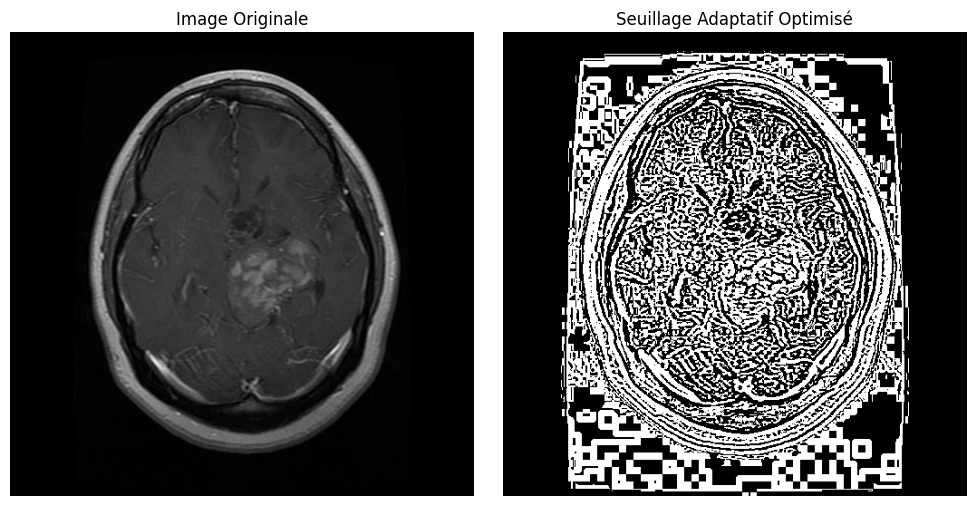

In [150]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_local

# Optimisation du seuillage adaptatif avec prétraitement supplémentaire si nécessaire.
def optimized_adaptive_thresholding(img):
    # Égaliser l'histogramme avant le seuillage pour améliorer les résultats.
    equalized_img = cv2.equalizeHist(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY))
    
    thresh = threshold_local(equalized_img.astype(np.float32), block_size=11) 
    binary_img = equalized_img > thresh  
    return binary_img.astype(np.uint8) * 255

# Charger une image pour démonstration
img_original = cv2.imread('Training/glioma_tumor/gg (1).jpg')  # Remplacez par le chemin de votre image

# Seuillage adaptatif optimisé sur l'image prétraitée
adaptive_thresh_optimized = optimized_adaptive_thresholding(img_original)

# Visualisation des résultats optimisés du seuillage adaptatif
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.title('Image Originale')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(adaptive_thresh_optimized, cmap='gray')
plt.title('Seuillage Adaptatif Optimisé')
plt.axis('off')

plt.tight_layout()


plt.show()


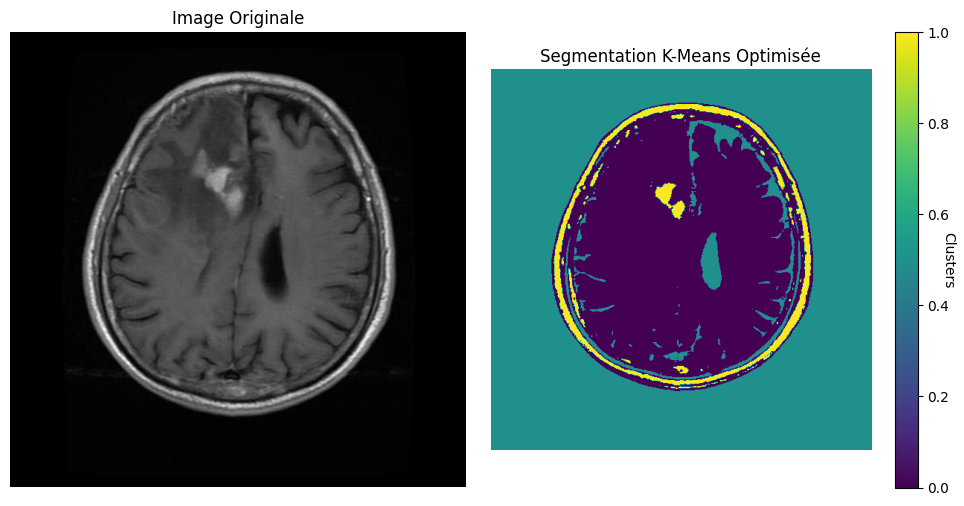

In [154]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Optimisation de la méthode K-Means
def optimized_kmeans_segmentation(img, n_clusters=3):
    img_flat = img.flatten().reshape(-1, 1)
    
    # Utilisation d'un nombre fixe d'itérations et d'un nombre d'initialisations pour améliorer la convergence.
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) 
    labels = kmeans.fit_predict(img_flat)
    
    return labels.reshape(img.shape)

# Charger une image pour démonstration
img_original = cv2.imread('Training/glioma_tumor/gg (5).jpg')  # Remplacez par le chemin de votre image
img_preprocessed = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)  # Exemple de prétraitement

# Segmentation optimisée avec K-Means
kmeans_segmented_optimized = optimized_kmeans_segmentation(img_preprocessed)

# Visualisation des résultats optimisés avec une nouvelle colormap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.title('Image Originale')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(kmeans_segmented_optimized, cmap='viridis')  # Changement de colormap ici
plt.title('Segmentation K-Means Optimisée')
plt.axis('off')

# Ajouter une légende pour les couleurs
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=plt.gca(), orientation='vertical')
cbar.set_label('Clusters', rotation=270)

plt.tight_layout()
plt.show()
